# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [2]:
#importing some useful packages
# import sys
# sys.path.append('/Users/shubhiitr/anaconda2/envs/drive/lib/python3.5/site-packages/')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


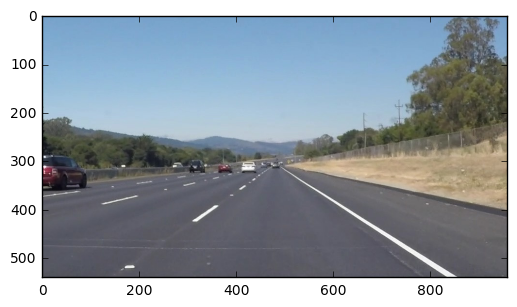

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [11]:
import os
import copy
files = os.listdir("test_images/")
ind   = 0
for i in files:
    files[ind] = "test_images/"+i
    ind = ind + 1

# image      = mpimg.imread(files[3])
# plt.imshow(image)

run your solution on all test_images and make copies into the test_images directory).

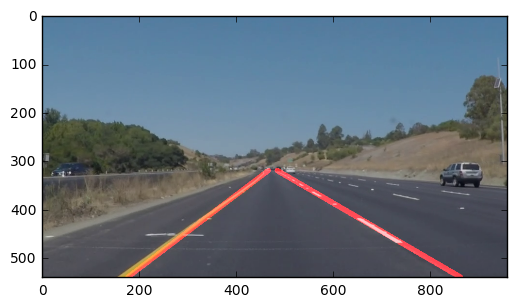

In [12]:
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# files = os.listdir("test_images/")
# ind   = 0
# for i in files:
#     files[ind] = "test_images/"+i
#     ind = ind + 1
# image      = mpimg.imread(files[5])
    
clip  = VideoFileClip('solidYellowLeft.mp4')
image = clip.get_frame(11.5)
plt.imshow(image)
image_copy = np.copy(image)
plt.imshow(image)

gray = grayscale(image)

kernel_size = 5
blur_gray   = gaussian_blur(gray,(kernel_size))

low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)

# This time we are defining a four sided polygon to mask
imshape      = image.shape
upper_bound  = 320
vertices     = np.array([[(180,imshape[0]),(440, 320), (imshape[1]-450, 320), (imshape[1]-50,imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
# print(masked_edges)

rho          = 2 # distance resolution in pixels of the Hough grid
theta        = np.pi/180 # angular resolution in radians of the Hough grid
threshold    = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40 #minimum number of pixels making up a line 50-10
max_line_gap = 20    # maximum gap in pixels between connectable line segments

# hough_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)


# line_edges = weighted_img(hough_image, image)
# plt.imshow(line_edges)
# draw_lines(img, lines, color=[255, 0, 0], thickness=2)

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
# print(lines)

# len(lines[1][0])
slopes = [[],[],[],[]]
left  = [[],[],[]]
right = [[],[],[]]

for line in lines:
    for x1,y1,x2,y2 in line:
        m = ((y2 - y1)/(x2 - x1))
        
        if m > 0 :
            left[0].append(m)
            left[1].append(x1)
            left[1].append(x2)
            left[2].append(y1)
            left[2].append(y2)
            
        else:
            right[0].append(m)
            right[1].append(x1)
            right[1].append(x2)
            right[2].append(y1)
            right[2].append(y2)

line_coef   = [[0,1],[0,1]]
line_coef[0] = np.polyfit(left[1],left[2],1)
line_coef[1] = np.polyfit(right[1],right[2],1)
new_lines    = []
  
for i in [0,1]:
    m  = line_coef[i][0]
    c  = line_coef[i][1]
    y1 = upper_bound
    x1 = int(round((y1 - c)/m))
    y2 = imshape[0]
    x2 = int(round((y2 - c)/m))
    new_lines.append([[x1, y1, x2, y2]])

# print(lines)
new_line_img  = np.copy(image)*0 # creating a blank to draw lines on

draw_lines(new_line_img, new_lines,[255, 0, 0],10)
final_image = weighted_img(new_line_img, image, 0.8, 0.8)
plt.imshow(final_image)

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    gray = grayscale(image)

    kernel_size = 5
    blur_gray   = gaussian_blur(gray,(kernel_size))

    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    imshape      = image.shape
    upper_bound  = 320
    vertices     = np.array([[(180,imshape[0]),(440, 320), (imshape[1]-450, 320), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    rho          = 2 # distance resolution in pixels of the Hough grid
    theta        = np.pi/180 # angular resolution in radians of the Hough grid
    threshold    = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line 50-10
    max_line_gap = 20    # maximum gap in pixels between connectable line segments

    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)

    left  = [[],[],[]]
    right = [[],[],[]]

    for line in lines:
        for x1,y1,x2,y2 in line:
            m = ((y2 - y1)/(x2 - x1))

            if m > 0 :
                left[0].append(m)
                left[1].append(x1)
                left[1].append(x2)
                left[2].append(y1)
                left[2].append(y2)

            else:
                right[0].append(m)
                right[1].append(x1)
                right[1].append(x2)
                right[2].append(y1)
                right[2].append(y2)

    line_coef = [[0,0],[0,0]]
    error     = 1
    global prev_coef 
    
    try:
        prev_coef
    except:
        error = 0
    
    if len(left[0]):
        line_coef[0] = np.polyfit(left[1],left[2],1)
    else:
        line_coef[0] = copy.deepcopy(prev_coef[0])
        
    if len(right[0]):
        line_coef[1] = np.polyfit(right[1],right[2],1)
    else:
        line_coef[1] = copy.deepcopy(prev_coef[1])

    new_lines    = []
    
    
    for i in [0,1]:
        m  = line_coef[i][0]
        c  = line_coef[i][1]
        
        if error:
            if abs(m - prev_coef[i][0]) > 0.3:
                line_coef[i] = copy.deepcopy(prev_coef[i])
                m  = line_coef[i][0]
                c  = line_coef[i][1]
            
        y1 = upper_bound
        x1 = int(round((y1 - c)/m))
        y2 = imshape[0]
        x2 = int(round((y2 - c)/m))
        new_lines.append([[x1, y1, x2, y2]])
        
    prev_coef = copy.deepcopy(line_coef)
    new_line_img  = np.copy(image)*0

    draw_lines(new_line_img, new_lines,[255, 0, 0],10)
    final_image = weighted_img(new_line_img, image, 0.8, 0.8)

    return final_image

Let's try the one with the solid white lane on the right first ...

In [14]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 31.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.53 s, sys: 1.03 s, total: 4.55 s
Wall time: 7.91 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [16]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:21<00:00, 31.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 10.8 s, sys: 2.91 s, total: 13.7 s
Wall time: 22.8 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


In [ ]:
# The algorithm cane be made even better by ensuring it automatically picks up the vertices of the masking algorithm 
# rather than hard coding it. The current algorithm is likely to fail when there is a very sharp turn or when the lanes 
# are not properly marked or in night conditions.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [110]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[array([   0.29321565,  227.18134651]), array([ -1.56246174e-01,   5.77697749e+02])]
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
yes
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  0.59383118,  25.88686186]), array([ -1.56246174e-01,   5.77697749e+02])]
yes
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4









  0%|          | 0/251 [00:00<?, ?it/s]






  1%|          | 2/251 [00:00<00:14, 16.92it/s]

[array([   0.29321565,  227.18134651]), array([ -1.56246174e-01,   5.77697749e+02])]
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
yes
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  0.59383118,  25.88686186]), array([ -1.56246174e-01,   5.77697749e+02])]
yes
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  1.38176733e-03,   4.60111616e+02]), array([ -6.66091199e-02,   5.24818485e+02])]
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
yes
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  0.59383118,  25.88686186]), array([ -6.66091199e-02,   5.24818485e+02])]
yes
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  1.68287866e-01, 

[array([  1.35450624e-01,   3.18466935e+02]), array([ -1.05837441e-01,   5.40372953e+02])]
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
yes
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  0.59383118,  25.88686186]), array([ -1.05837441e-01,   5.40372953e+02])]
yes
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]









  2%|▏         | 5/251 [00:00<00:14, 17.56it/s]

[array([   0.26872732,  238.42988015]), array([ -2.04882776e-01,   6.12234273e+02])]
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
yes
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  0.59383118,  25.88686186]), array([ -2.04882776e-01,   6.12234273e+02])]
yes
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  1.96591820e-01,   2.86101470e+02]), array([ -1.30421117e-01,   5.72805417e+02])]
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
yes
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  0.59383118,  25.88686186]), array([ -1.30421117e-01,   5.72805417e+02])]
yes
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([  2.42848300e-01, 








  3%|▎         | 8/251 [00:00<00:13, 18.52it/s]

[array([   0.33599437,  183.87271299]), array([ -6.14491800e-02,   5.37440915e+02])]









  4%|▍         | 10/251 [00:00<00:13, 17.89it/s]

[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
yes
[array([  0.59383118,  25.88686186]), array([  -0.75715287,  670.41601308])]
[array([   0.33599437,  183.87271299]), array([  -0.75715287,  670.41601308])]
[array([   0.25076236,  248.87098123]), array([ -5.86293071e-02,   5.08242636e+02])]
[array([   0.33599437,  183.87271299]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.33599437,  183.87271299]), array([  -0.75715287,  670.41601308])]
[array([   0.25076236,  248.87098123]), array([  -0.75715287,  670.41601308])]
[array([   0.31720064,  204.39978144]), array([ -1.15451918e-01,   5.49445800e+02])]
[array([   0.25076236,  248.87098123]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.25076236,  248.87098123]), array([  -0.75715287,  670.41601308])]
[array([   0.31720064,  204.39978144]), array([  -0.75715287,  670.41601308])]









  5%|▍         | 12/251 [00:00<00:15, 15.19it/s]

[array([   0.39836576,  143.76722451]), array([ -2.30654668e-02,   5.02684318e+02])]
[array([   0.31720064,  204.39978144]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.31720064,  204.39978144]), array([  -0.75715287,  670.41601308])]
[array([   0.39836576,  143.76722451]), array([  -0.75715287,  670.41601308])]
[array([   0.38396482,  153.79433655]), array([ -2.44455656e-02,   4.96832689e+02])]
[array([   0.39836576,  143.76722451]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.39836576,  143.76722451]), array([  -0.75715287,  670.41601308])]
[array([   0.38396482,  153.79433655]), array([  -0.75715287,  670.41601308])]









  6%|▌         | 14/251 [00:00<00:17, 13.24it/s]






  7%|▋         | 17/251 [00:01<00:15, 15.09it/s]

[array([  1.06427826e-01,   3.86951270e+02]), array([ -1.96732160e-01,   6.27476503e+02])]
[array([   0.38396482,  153.79433655]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.38396482,  153.79433655]), array([  -0.75715287,  670.41601308])]
[array([  1.06427826e-01,   3.86951270e+02]), array([  -0.75715287,  670.41601308])]
[array([  5.64605114e-02,   3.94160902e+02]), array([ -6.26178159e-02,   5.50711757e+02])]
[array([  1.06427826e-01,   3.86951270e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.06427826e-01,   3.86951270e+02]), array([  -0.75715287,  670.41601308])]
[array([  5.64605114e-02,   3.94160902e+02]), array([  -0.75715287,  670.41601308])]
[array([ -2.41703934e-01,   6.31990267e+02]), array([ -1.60735601e-01,   5.93417999e+02])]
[array([  5.64605114e-02,   3.94160902e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  5.64605114e-02,   3.94160902e+02]), array([  -0.75715287,  670.41601308])]
[array([  5.64605114e-02,   3.94160902e+02]), a








  8%|▊         | 20/251 [00:01<00:13, 16.85it/s]






  9%|▉         | 23/251 [00:01<00:12, 18.27it/s]

[array([ -2.43867066e-02,   4.65306439e+02]), array([ -1.48392860e-01,   5.80986654e+02])]
[array([  1.31924014e-01,   3.31780222e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.31924014e-01,   3.31780222e+02]), array([  -0.75715287,  670.41601308])]
[array([ -2.43867066e-02,   4.65306439e+02]), array([  -0.75715287,  670.41601308])]
[array([ -5.82678649e-02,   4.76307762e+02]), array([ -2.14604467e-01,   6.33931921e+02])]
[array([ -2.43867066e-02,   4.65306439e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -2.43867066e-02,   4.65306439e+02]), array([  -0.75715287,  670.41601308])]
[array([ -5.82678649e-02,   4.76307762e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.30363877,  199.3804014 ]), array([ -1.09744979e-01,   5.50852576e+02])]
[array([ -5.82678649e-02,   4.76307762e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -5.82678649e-02,   4.76307762e+02]), array([  -0.75715287,  670.41601308])]
[array([ -5.82678649e-02,   4.76307762e+0








 10%|▉         | 25/251 [00:01<00:12, 18.10it/s]






 11%|█         | 28/251 [00:01<00:11, 19.48it/s]

[array([ 0.56540807,  5.77097145]), array([ -1.31372104e-01,   5.54877098e+02])]
[array([  1.26829181e-01,   3.45425766e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.26829181e-01,   3.45425766e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.26829181e-01,   3.45425766e+02]), array([ -1.31372104e-01,   5.54877098e+02])]
yes
[array([  1.26829181e-01,   3.45425766e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.26829181e-01,   3.45425766e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.4356177 ,  103.72618242]), array([ -1.99845595e-01,   5.99890010e+02])]
[array([  1.26829181e-01,   3.45425766e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.26829181e-01,   3.45425766e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.26829181e-01,   3.45425766e+02]), array([ -1.99845595e-01,   5.99890010e+02])]
yes
[array([  1.26829181e-01,   3.45425766e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.26829181e-01,   3.45425766e+0








 12%|█▏        | 31/251 [00:01<00:10, 20.69it/s]

[array([  1.23013049e-02,   4.32146784e+02]), array([ -2.41388939e-01,   6.33520645e+02])]
[array([  3.18166605e-02,   4.13817729e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  3.18166605e-02,   4.13817729e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.23013049e-02,   4.32146784e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.27680935e-01,   2.63095821e+02]), array([  2.45596970e-03,   4.82445661e+02])]
[array([  1.23013049e-02,   4.32146784e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.23013049e-02,   4.32146784e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.27680935e-01,   2.63095821e+02]), array([  -0.75715287,  670.41601308])]
[array([  6.30963730e-02,   3.87848299e+02]), array([ -1.12579744e-01,   5.36257356e+02])]
[array([  2.27680935e-01,   2.63095821e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.27680935e-01,   2.63095821e+02]), array([  -0.75715287,  670.41601308])]
[array([  6.30963730e-02,   3.87848








 14%|█▎        | 34/251 [00:01<00:11, 18.52it/s]

[array([  3.86173117e-03,   4.30658940e+02]), array([ -1.09259044e-01,   5.65060989e+02])]
[array([  5.43071963e-02,   4.08305456e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  5.43071963e-02,   4.08305456e+02]), array([  -0.75715287,  670.41601308])]
[array([  3.86173117e-03,   4.30658940e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.27327979,  242.59628545]), array([ -1.74414796e-01,   5.85838348e+02])]
[array([  3.86173117e-03,   4.30658940e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  3.86173117e-03,   4.30658940e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.27327979,  242.59628545]), array([  -0.75715287,  670.41601308])]
[array([   0.2851169 ,  214.77181778]), array([ -2.03158868e-01,   6.15360314e+02])]
[array([   0.27327979,  242.59628545]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.27327979,  242.59628545]), array([  -0.75715287,  670.41601308])]
[array([   0.2851169 ,  214.77181778]), array([  -0.75715287,  67








 14%|█▍        | 36/251 [00:02<00:12, 16.98it/s]






 15%|█▌        | 38/251 [00:02<00:14, 15.02it/s]

[array([  2.52238429e-01,   2.62790590e+02]), array([ -1.48609421e-01,   5.60459820e+02])]
[array([   0.2851169 ,  214.77181778]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.2851169 ,  214.77181778]), array([  -0.75715287,  670.41601308])]
[array([  2.52238429e-01,   2.62790590e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.32719162,  182.94270119]), array([ -7.61908297e-02,   5.07604511e+02])]
[array([  2.52238429e-01,   2.62790590e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.52238429e-01,   2.62790590e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.32719162,  182.94270119]), array([  -0.75715287,  670.41601308])]
[array([  2.32032056e-01,   2.81982845e+02]), array([ -8.84301851e-02,   5.25875996e+02])]
[array([   0.32719162,  182.94270119]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.32719162,  182.94270119]), array([  -0.75715287,  670.41601308])]
[array([  2.32032056e-01,   2.81982845e+02]), array([  -0.75715287,  67








 16%|█▌        | 40/251 [00:02<00:15, 14.04it/s]

[array([  5.91528825e-02,   3.92564309e+02]), array([ -1.54445239e-01,   5.93152507e+02])]
[array([  2.32032056e-01,   2.81982845e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.32032056e-01,   2.81982845e+02]), array([  -0.75715287,  670.41601308])]
[array([  5.91528825e-02,   3.92564309e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.86786944e-01,   2.94135970e+02]), array([ -1.71372270e-01,   5.79519994e+02])]
[array([  5.91528825e-02,   3.92564309e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  5.91528825e-02,   3.92564309e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.86786944e-01,   2.94135970e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.32078003,  190.93821036]), array([ -1.61478259e-01,   5.53220936e+02])]
[array([  1.86786944e-01,   2.94135970e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.86786944e-01,   2.94135970e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.32078003,  190.93821036]), a








 17%|█▋        | 42/251 [00:02<00:15, 13.87it/s]






 18%|█▊        | 44/251 [00:02<00:15, 13.08it/s]

[array([  2.11393239e-01,   2.71191382e+02]), array([  6.67187127e-02,   4.21235001e+02])]
[array([   0.32078003,  190.93821036]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.32078003,  190.93821036]), array([  -0.75715287,  670.41601308])]
[array([  2.11393239e-01,   2.71191382e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.2973024 ,  220.87811628]), array([ -3.09329443e-01,   6.60478129e+02])]
[array([  2.11393239e-01,   2.71191382e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.11393239e-01,   2.71191382e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.2973024 ,  220.87811628]), array([  -0.75715287,  670.41601308])]
[array([  2.16460040e-01,   2.76461176e+02]), array([ -1.24040523e-01,   5.52432135e+02])]
[array([   0.2973024 ,  220.87811628]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.2973024 ,  220.87811628]), array([  -0.75715287,  670.41601308])]
[array([  2.16460040e-01,   2.76461176e+02]), array([  -0.75715287,  67








 18%|█▊        | 46/251 [00:02<00:16, 12.40it/s]

[array([   0.3889209,  160.9541064]), array([ -2.56029780e-01,   6.01962551e+02])]
[array([  2.16460040e-01,   2.76461176e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.16460040e-01,   2.76461176e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.3889209,  160.9541064]), array([  -0.75715287,  670.41601308])]
[array([  1.51837573e-01,   3.35076889e+02]), array([ -1.25635182e-01,   5.32651773e+02])]
[array([   0.3889209,  160.9541064]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.3889209,  160.9541064]), array([  -0.75715287,  670.41601308])]
[array([  1.51837573e-01,   3.35076889e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.28849073,  231.84067061]), array([ -8.30925698e-02,   5.24201796e+02])]
[array([  1.51837573e-01,   3.35076889e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.51837573e-01,   3.35076889e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.28849073,  231.84067061]), array([  -0.75715287,  670.416013








 19%|█▉        | 48/251 [00:02<00:15, 12.85it/s]






 20%|█▉        | 50/251 [00:03<00:15, 12.77it/s]

[array([   0.27304412,  256.31132631]), array([ -3.94902399e-02,   4.73188083e+02])]
[array([   0.28849073,  231.84067061]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.28849073,  231.84067061]), array([  -0.75715287,  670.41601308])]
[array([   0.27304412,  256.31132631]), array([  -0.75715287,  670.41601308])]
[array([   0.39925774,  150.3891291 ]), array([ -3.96053234e-02,   4.88311906e+02])]
[array([   0.27304412,  256.31132631]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.27304412,  256.31132631]), array([  -0.75715287,  670.41601308])]
[array([   0.39925774,  150.3891291 ]), array([  -0.75715287,  670.41601308])]
[array([   0.41071977,  155.89920368]), array([ -6.21129212e-02,   4.99588140e+02])]
[array([   0.39925774,  150.3891291 ]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.39925774,  150.3891291 ]), array([  -0.75715287,  670.41601308])]
[array([   0.41071977,  155.89920368]), array([  -0.75715287,  670.41601308])]









 21%|██        | 52/251 [00:03<00:15, 12.93it/s]

[array([   0.3002443 ,  218.88665376]), array([ -2.27850869e-01,   5.85600694e+02])]
[array([   0.41071977,  155.89920368]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.41071977,  155.89920368]), array([  -0.75715287,  670.41601308])]
[array([   0.3002443 ,  218.88665376]), array([  -0.75715287,  670.41601308])]
[array([  2.25383792e-01,   2.64058207e+02]), array([ -1.01601363e-01,   5.21477089e+02])]
[array([   0.3002443 ,  218.88665376]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.3002443 ,  218.88665376]), array([  -0.75715287,  670.41601308])]
[array([  2.25383792e-01,   2.64058207e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.79902049e-01,   2.96599841e+02]), array([  3.59477510e-02,   4.42844230e+02])]
[array([  2.25383792e-01,   2.64058207e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.25383792e-01,   2.64058207e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.79902049e-01,   2.96599841e+02]), array([  -0.75715287,  67








 22%|██▏       | 54/251 [00:03<00:17, 11.53it/s]

[array([  2.19224499e-01,   2.69661490e+02]), array([ -8.69159735e-02,   5.05615388e+02])]
[array([  1.79902049e-01,   2.96599841e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.79902049e-01,   2.96599841e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.19224499e-01,   2.69661490e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.29576533,  220.94584058]), array([ -1.83833756e-03,   4.63631267e+02])]
[array([  2.19224499e-01,   2.69661490e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.19224499e-01,   2.69661490e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.29576533,  220.94584058]), array([  -0.75715287,  670.41601308])]









 22%|██▏       | 56/251 [00:03<00:20,  9.68it/s]






 23%|██▎       | 58/251 [00:03<00:17, 10.94it/s]

[array([   0.25415387,  244.82013517]), array([ -1.56732766e-01,   5.42057838e+02])]
[array([   0.29576533,  220.94584058]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.29576533,  220.94584058]), array([  -0.75715287,  670.41601308])]
[array([   0.25415387,  244.82013517]), array([  -0.75715287,  670.41601308])]
[array([   0.28154678,  240.57949168]), array([ -7.02132506e-02,   5.04336896e+02])]
[array([   0.25415387,  244.82013517]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.25415387,  244.82013517]), array([  -0.75715287,  670.41601308])]
[array([   0.28154678,  240.57949168]), array([  -0.75715287,  670.41601308])]
[array([  2.40645699e-01,   2.61988343e+02]), array([ -4.24017741e-02,   4.71348045e+02])]
[array([   0.28154678,  240.57949168]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.28154678,  240.57949168]), array([  -0.75715287,  670.41601308])]
[array([  2.40645699e-01,   2.61988343e+02]), array([  -0.75715287,  670.41601308])]
[array([  








 24%|██▍       | 60/251 [00:04<00:16, 11.77it/s]






 25%|██▍       | 62/251 [00:04<00:15, 12.33it/s]

[array([   0.30662762,  222.21160001]), array([  6.89063584e-02,   4.10209890e+02])]
[array([   0.33677754,  200.67517373]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.33677754,  200.67517373]), array([  -0.75715287,  670.41601308])]
[array([   0.30662762,  222.21160001]), array([  -0.75715287,  670.41601308])]
[array([  2.44710413e-01,   2.66175564e+02]), array([  1.94391340e-02,   4.37702023e+02])]
[array([   0.30662762,  222.21160001]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.30662762,  222.21160001]), array([  -0.75715287,  670.41601308])]
[array([  2.44710413e-01,   2.66175564e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.06500843e-01,   3.57490533e+02]), array([ -1.61600721e-02,   4.61455056e+02])]
[array([  2.44710413e-01,   2.66175564e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.44710413e-01,   2.66175564e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.06500843e-01,   3.57490533e+02]), array([  -0.75715287,  67








 25%|██▌       | 64/251 [00:04<00:15, 11.79it/s]

[array([  1.27420327e-01,   3.17960476e+02]), array([  9.65625784e-02,   3.96721464e+02])]
[array([  1.06500843e-01,   3.57490533e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.06500843e-01,   3.57490533e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.27420327e-01,   3.17960476e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.76639544e-01,   2.84137312e+02]), array([  3.15781091e-02,   4.23783299e+02])]
[array([  1.27420327e-01,   3.17960476e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.27420327e-01,   3.17960476e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.76639544e-01,   2.84137312e+02]), array([  -0.75715287,  670.41601308])]









 26%|██▋       | 66/251 [00:04<00:23,  7.76it/s]

[array([  1.45058024e-01,   3.14557523e+02]), array([  1.64379171e-02,   4.39507253e+02])]
[array([  1.76639544e-01,   2.84137312e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.76639544e-01,   2.84137312e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.45058024e-01,   3.14557523e+02]), array([  -0.75715287,  670.41601308])]
[array([  7.31742636e-02,   3.66936419e+02]), array([  1.58679240e-04,   4.38271761e+02])]
[array([  1.45058024e-01,   3.14557523e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.45058024e-01,   3.14557523e+02]), array([  -0.75715287,  670.41601308])]
[array([  7.31742636e-02,   3.66936419e+02]), array([  -0.75715287,  670.41601308])]









 27%|██▋       | 67/251 [00:04<00:23,  7.69it/s]






 27%|██▋       | 68/251 [00:05<00:23,  7.85it/s]

[array([  1.55916627e-01,   3.07414475e+02]), array([  6.91261569e-02,   4.19156829e+02])]
[array([  7.31742636e-02,   3.66936419e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  7.31742636e-02,   3.66936419e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.55916627e-01,   3.07414475e+02]), array([  -0.75715287,  670.41601308])]
[array([  8.10421243e-02,   3.55204905e+02]), array([ -3.72173406e-03,   4.44998308e+02])]
[array([  1.55916627e-01,   3.07414475e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.55916627e-01,   3.07414475e+02]), array([  -0.75715287,  670.41601308])]
[array([  8.10421243e-02,   3.55204905e+02]), array([  -0.75715287,  670.41601308])]









 27%|██▋       | 69/251 [00:05<00:22,  7.92it/s]






 28%|██▊       | 71/251 [00:05<00:19,  9.10it/s]

[array([   0.29593871,  230.00160872]), array([  9.14667533e-03,   4.35028318e+02])]
[array([  8.10421243e-02,   3.55204905e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  8.10421243e-02,   3.55204905e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.29593871,  230.00160872]), array([  -0.75715287,  670.41601308])]
[array([   0.27865543,  217.05019568]), array([ -1.66860241e-02,   4.53627506e+02])]
[array([   0.29593871,  230.00160872]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.29593871,  230.00160872]), array([  -0.75715287,  670.41601308])]
[array([   0.27865543,  217.05019568]), array([  -0.75715287,  670.41601308])]
[array([   0.31364155,  221.93165263]), array([ -9.11673873e-02,   5.00447866e+02])]
[array([   0.27865543,  217.05019568]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.27865543,  217.05019568]), array([  -0.75715287,  670.41601308])]
[array([   0.31364155,  221.93165263]), array([  -0.75715287,  670.41601308])]









 29%|██▉       | 73/251 [00:05<00:17, 10.07it/s]

[array([   0.26952972,  237.08186854]), array([ -8.36573701e-03,   4.56833213e+02])]
[array([   0.31364155,  221.93165263]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.31364155,  221.93165263]), array([  -0.75715287,  670.41601308])]
[array([   0.26952972,  237.08186854]), array([  -0.75715287,  670.41601308])]
[array([  2.05711498e-01,   2.81580149e+02]), array([ -1.89442151e-02,   4.58808018e+02])]
[array([   0.26952972,  237.08186854]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.26952972,  237.08186854]), array([  -0.75715287,  670.41601308])]
[array([  2.05711498e-01,   2.81580149e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.73534338e-01,   2.87442598e+02]), array([ -7.28570233e-02,   4.85025390e+02])]
[array([  2.05711498e-01,   2.81580149e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.05711498e-01,   2.81580149e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.73534338e-01,   2.87442598e+02]), array([  -0.75715287,  67








 30%|██▉       | 75/251 [00:05<00:15, 11.15it/s]






 31%|███       | 77/251 [00:05<00:15, 11.31it/s]

[array([  8.13832492e-02,   3.63605816e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.08639883e-01,   3.36084122e+02]), array([  2.26374973e-04,   4.57256304e+02])]
[array([  8.13832492e-02,   3.63605816e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  8.13832492e-02,   3.63605816e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.08639883e-01,   3.36084122e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.19833183e-01,   3.42960932e+02]), array([ -8.58914035e-02,   5.02774192e+02])]
[array([  1.08639883e-01,   3.36084122e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.08639883e-01,   3.36084122e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.19833183e-01,   3.42960932e+02]), array([  -0.75715287,  670.41601308])]









 31%|███▏      | 79/251 [00:05<00:14, 12.10it/s]

[array([  5.96407070e-02,   3.79697177e+02]), array([ -2.52442091e-02,   4.87764863e+02])]
[array([  1.19833183e-01,   3.42960932e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.19833183e-01,   3.42960932e+02]), array([  -0.75715287,  670.41601308])]
[array([  5.96407070e-02,   3.79697177e+02]), array([  -0.75715287,  670.41601308])]
[array([  9.94327790e-02,   3.63979020e+02]), array([ -9.32911165e-02,   5.08692608e+02])]
[array([  5.96407070e-02,   3.79697177e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  5.96407070e-02,   3.79697177e+02]), array([  -0.75715287,  670.41601308])]
[array([  9.94327790e-02,   3.63979020e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.25551185,  243.96218107]), array([ -1.20032933e-01,   5.25934493e+02])]
[array([  9.94327790e-02,   3.63979020e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  9.94327790e-02,   3.63979020e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.25551185,  243.96218107]), a








 32%|███▏      | 81/251 [00:06<00:14, 11.72it/s]






 33%|███▎      | 83/251 [00:06<00:14, 11.85it/s]

[array([  1.56231186e-01,   3.25063140e+02]), array([ -1.22339955e-01,   5.36299387e+02])]
[array([   0.25551185,  243.96218107]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.25551185,  243.96218107]), array([  -0.75715287,  670.41601308])]
[array([  1.56231186e-01,   3.25063140e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.17267214e-01,   2.69143526e+02]), array([ -7.25562145e-02,   5.14452175e+02])]
[array([  1.56231186e-01,   3.25063140e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.56231186e-01,   3.25063140e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.17267214e-01,   2.69143526e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.02872112e-01,   2.89358530e+02]), array([ -6.05900831e-02,   4.95021448e+02])]
[array([  2.17267214e-01,   2.69143526e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.17267214e-01,   2.69143526e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.02872112e-01,   2.89358530e+02]), a








 34%|███▍      | 85/251 [00:06<00:16, 10.32it/s]

[array([  2.42832981e-01,   2.70577774e+02]), array([ -8.75827343e-02,   5.14426496e+02])]
[array([  2.02872112e-01,   2.89358530e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.02872112e-01,   2.89358530e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.42832981e-01,   2.70577774e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.26435714e-02,   4.42699604e+02]), array([ -8.85625413e-02,   5.18697694e+02])]
[array([  2.42832981e-01,   2.70577774e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.42832981e-01,   2.70577774e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.26435714e-02,   4.42699604e+02]), array([  -0.75715287,  670.41601308])]
[array([ -2.45463226e-02,   4.38114214e+02]), array([  5.07233323e-02,   4.42364102e+02])]
[array([  1.26435714e-02,   4.42699604e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.26435714e-02,   4.42699604e+02]), array([  -0.75715287,  670.41601308])]
[array([ -2.45463226e-02,   4.38114








 35%|███▍      | 87/251 [00:06<00:15, 10.39it/s]






 35%|███▌      | 89/251 [00:06<00:14, 11.08it/s]

[array([ -8.52857989e-02,   4.80936805e+02]), array([ -7.35196427e-02,   5.09666005e+02])]
[array([ -2.45463226e-02,   4.38114214e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -2.45463226e-02,   4.38114214e+02]), array([  -0.75715287,  670.41601308])]
[array([ -8.52857989e-02,   4.80936805e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.29078276e-03,   4.23348816e+02]), array([ -1.53229307e-01,   5.63048380e+02])]
[array([ -8.52857989e-02,   4.80936805e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -8.52857989e-02,   4.80936805e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.29078276e-03,   4.23348816e+02]), array([  -0.75715287,  670.41601308])]
[array([ -5.91792449e-02,   4.87076495e+02]), array([ -1.58582086e-01,   5.66828323e+02])]
[array([  2.29078276e-03,   4.23348816e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.29078276e-03,   4.23348816e+02]), array([  -0.75715287,  670.41601308])]
[array([ -5.91792449e-02,   4.87076








 36%|███▋      | 91/251 [00:07<00:13, 11.81it/s]

[array([ -5.16055113e-02,   4.85733768e+02]), array([ -1.74663807e-01,   5.72506364e+02])]
[array([ -5.91792449e-02,   4.87076495e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -5.91792449e-02,   4.87076495e+02]), array([  -0.75715287,  670.41601308])]
[array([ -5.16055113e-02,   4.85733768e+02]), array([  -0.75715287,  670.41601308])]
[array([ -1.14962964e-01,   5.29914274e+02]), array([ -1.84123087e-01,   5.72820426e+02])]
[array([ -5.16055113e-02,   4.85733768e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -5.16055113e-02,   4.85733768e+02]), array([  -0.75715287,  670.41601308])]
[array([ -1.14962964e-01,   5.29914274e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.42046137e-02,   4.32858082e+02]), array([ -1.85999413e-01,   5.89536087e+02])]
[array([ -1.14962964e-01,   5.29914274e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -1.14962964e-01,   5.29914274e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.42046137e-02,   4.32858








 37%|███▋      | 93/251 [00:07<00:13, 12.03it/s]






 38%|███▊      | 95/251 [00:07<00:12, 12.68it/s]

[array([  5.43633843e-02,   4.24707618e+02]), array([ -1.97128089e-01,   5.84960294e+02])]
[array([  1.42046137e-02,   4.32858082e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.42046137e-02,   4.32858082e+02]), array([  -0.75715287,  670.41601308])]
[array([  5.43633843e-02,   4.24707618e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.01701352e-01,   3.62978178e+02]), array([ -1.45862810e-01,   5.57529796e+02])]
[array([  5.43633843e-02,   4.24707618e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  5.43633843e-02,   4.24707618e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.01701352e-01,   3.62978178e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.32979270e-01,   2.77379060e+02]), array([ -1.95356973e-01,   5.89986115e+02])]
[array([  1.01701352e-01,   3.62978178e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.01701352e-01,   3.62978178e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.32979270e-01,   2.77379








 39%|███▊      | 97/251 [00:07<00:12, 12.71it/s]

[array([  1.14080379e-01,   3.62591130e+02]), array([ -2.16594007e-01,   6.02112636e+02])]
[array([  2.32979270e-01,   2.77379060e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.32979270e-01,   2.77379060e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.14080379e-01,   3.62591130e+02]), array([  -0.75715287,  670.41601308])]
[array([ -4.84732706e-02,   4.78281403e+02]), array([ -2.03317772e-01,   6.01725696e+02])]
[array([  1.14080379e-01,   3.62591130e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.14080379e-01,   3.62591130e+02]), array([  -0.75715287,  670.41601308])]
[array([ -4.84732706e-02,   4.78281403e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.41756490e-02,   4.07185559e+02]), array([ -2.63922580e-01,   6.35233584e+02])]
[array([ -4.84732706e-02,   4.78281403e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -4.84732706e-02,   4.78281403e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.41756490e-02,   4.07185








 39%|███▉      | 99/251 [00:07<00:13, 11.56it/s]






 40%|████      | 101/251 [00:07<00:12, 11.85it/s]

[array([ -1.18808772e-01,   5.00560309e+02]), array([ -2.19603953e-01,   5.90864487e+02])]
[array([  2.41756490e-02,   4.07185559e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.41756490e-02,   4.07185559e+02]), array([  -0.75715287,  670.41601308])]
[array([ -1.18808772e-01,   5.00560309e+02]), array([  -0.75715287,  670.41601308])]
[array([  8.97185634e-02,   3.68202873e+02]), array([ -1.49267663e-01,   5.56343495e+02])]
[array([ -1.18808772e-01,   5.00560309e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -1.18808772e-01,   5.00560309e+02]), array([  -0.75715287,  670.41601308])]
[array([  8.97185634e-02,   3.68202873e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.32947398e-01,   2.52631158e+02]), array([ -2.10517784e-01,   6.01936259e+02])]
[array([  8.97185634e-02,   3.68202873e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  8.97185634e-02,   3.68202873e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.32947398e-01,   2.52631








 41%|████      | 103/251 [00:08<00:12, 11.62it/s]

[array([ -2.10103861e-02,   4.48274158e+02]), array([ -1.72236450e-01,   5.65270159e+02])]
[array([  2.32947398e-01,   2.52631158e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.32947398e-01,   2.52631158e+02]), array([  -0.75715287,  670.41601308])]
[array([ -2.10103861e-02,   4.48274158e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.20783005e-01,   3.43923975e+02]), array([ -9.94764076e-02,   5.11182578e+02])]
[array([ -2.10103861e-02,   4.48274158e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -2.10103861e-02,   4.48274158e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.20783005e-01,   3.43923975e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.71643175e-01,   3.12178190e+02]), array([ -8.91538224e-02,   4.90437514e+02])]
[array([  1.20783005e-01,   3.43923975e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.20783005e-01,   3.43923975e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.71643175e-01,   3.12178








 42%|████▏     | 105/251 [00:08<00:12, 12.11it/s]






 43%|████▎     | 107/251 [00:08<00:11, 12.25it/s]

[array([  8.96251729e-02,   3.59746919e+02]), array([ -4.17540680e-02,   4.74337703e+02])]
[array([  1.71643175e-01,   3.12178190e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.71643175e-01,   3.12178190e+02]), array([  -0.75715287,  670.41601308])]
[array([  8.96251729e-02,   3.59746919e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.32569762e-01,   2.65856614e+02]), array([ -1.59878680e-01,   5.68645389e+02])]
[array([  8.96251729e-02,   3.59746919e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  8.96251729e-02,   3.59746919e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.32569762e-01,   2.65856614e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.43735650e-01,   2.60258593e+02]), array([ -1.75759686e-02,   4.69128646e+02])]
[array([  2.32569762e-01,   2.65856614e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.32569762e-01,   2.65856614e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.43735650e-01,   2.60258








 43%|████▎     | 109/251 [00:08<00:11, 12.18it/s]

[array([  2.51785693e-01,   2.56348397e+02]), array([  1.32075612e-01,   3.83809622e+02])]
[array([  2.43735650e-01,   2.60258593e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.43735650e-01,   2.60258593e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.51785693e-01,   2.56348397e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.27873087,  242.34996238]), array([  1.33417502e-01,   3.94699637e+02])]
[array([  2.51785693e-01,   2.56348397e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.51785693e-01,   2.56348397e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.27873087,  242.34996238]), array([  -0.75715287,  670.41601308])]
[array([   0.30306508,  246.96440939]), array([  1.13260254e-01,   4.04906493e+02])]
[array([   0.27873087,  242.34996238]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.27873087,  242.34996238]), array([  -0.75715287,  670.41601308])]
[array([   0.30306508,  246.96440939]), array([  -0.75715287,  67








 44%|████▍     | 111/251 [00:08<00:10, 12.77it/s]






 45%|████▌     | 113/251 [00:08<00:10, 13.01it/s]

[array([  2.08514206e-01,   2.81426619e+02]), array([  2.06278850e-02,   4.25195598e+02])]
[array([   0.30306508,  246.96440939]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.30306508,  246.96440939]), array([  -0.75715287,  670.41601308])]
[array([  2.08514206e-01,   2.81426619e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.03606059e-01,   2.93381892e+02]), array([ -1.23095529e-01,   5.02115155e+02])]
[array([  2.08514206e-01,   2.81426619e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.08514206e-01,   2.81426619e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.03606059e-01,   2.93381892e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.85529874e-01,   2.86448165e+02]), array([ -7.64563030e-02,   4.74509300e+02])]
[array([  2.03606059e-01,   2.93381892e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.03606059e-01,   2.93381892e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.85529874e-01,   2.86448165e+02]), a








 46%|████▌     | 115/251 [00:08<00:10, 12.64it/s]

[array([  9.61934725e-02,   3.51411234e+02]), array([  6.38358200e-02,   3.87047744e+02])]
[array([  1.85529874e-01,   2.86448165e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.85529874e-01,   2.86448165e+02]), array([  -0.75715287,  670.41601308])]
[array([  9.61934725e-02,   3.51411234e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.25360705e-01,   2.54264948e+02]), array([ -9.14841277e-02,   4.67351532e+02])]
[array([  9.61934725e-02,   3.51411234e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  9.61934725e-02,   3.51411234e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.25360705e-01,   2.54264948e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.94510207e-01,   3.02209242e+02]), array([ -2.99003713e-02,   4.60360270e+02])]
[array([  2.25360705e-01,   2.54264948e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.25360705e-01,   2.54264948e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.94510207e-01,   3.02209








 47%|████▋     | 117/251 [00:09<00:10, 12.94it/s]

[array([   0.28141264,  211.11490662]), array([ -1.18301988e-01,   4.99093463e+02])]
[array([  1.94510207e-01,   3.02209242e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.94510207e-01,   3.02209242e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.28141264,  211.11490662]), array([  -0.75715287,  670.41601308])]
[array([   0.27075379,  219.03797066]), array([  2.68897551e-02,   4.22669125e+02])]
[array([   0.28141264,  211.11490662]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.28141264,  211.11490662]), array([  -0.75715287,  670.41601308])]
[array([   0.27075379,  219.03797066]), array([  -0.75715287,  670.41601308])]









 47%|████▋     | 119/251 [00:09<00:13,  9.43it/s]






 48%|████▊     | 121/251 [00:09<00:12, 10.63it/s]

[array([  1.03056281e-01,   3.58124825e+02]), array([  1.86363404e-02,   4.26617854e+02])]
[array([   0.27075379,  219.03797066]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.27075379,  219.03797066]), array([  -0.75715287,  670.41601308])]
[array([  1.03056281e-01,   3.58124825e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.55009621e-01,   3.34879185e+02]), array([ -5.71972281e-02,   4.74476459e+02])]
[array([  1.03056281e-01,   3.58124825e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.03056281e-01,   3.58124825e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.55009621e-01,   3.34879185e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.25916538,  239.11279933]), array([  4.50339630e-02,   4.13814881e+02])]
[array([  1.55009621e-01,   3.34879185e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.55009621e-01,   3.34879185e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.25916538,  239.11279933]), array([  -0.7








 49%|████▉     | 123/251 [00:09<00:11, 11.25it/s]

[array([   0.2974025 ,  232.67885493]), array([  1.16435914e-02,   4.32321894e+02])]
[array([   0.25916538,  239.11279933]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.25916538,  239.11279933]), array([  -0.75715287,  670.41601308])]
[array([   0.2974025 ,  232.67885493]), array([  -0.75715287,  670.41601308])]
[array([  1.06514297e-01,   3.56201278e+02]), array([  1.30720553e-01,   3.66833627e+02])]
[array([   0.2974025 ,  232.67885493]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.2974025 ,  232.67885493]), array([  -0.75715287,  670.41601308])]
[array([  1.06514297e-01,   3.56201278e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.28869768,  217.12139774]), array([  9.49271988e-02,   3.81677020e+02])]
[array([  1.06514297e-01,   3.56201278e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.06514297e-01,   3.56201278e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.28869768,  217.12139774]), array([  -0.75715287,  670.41601308])








 50%|████▉     | 125/251 [00:09<00:11, 10.64it/s]






 51%|█████     | 127/251 [00:10<00:10, 11.37it/s]

[array([  7.60456450e-02,   3.68606354e+02]), array([ -2.74052742e-02,   4.56968492e+02])]
[array([   0.28869768,  217.12139774]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.28869768,  217.12139774]), array([  -0.75715287,  670.41601308])]
[array([  7.60456450e-02,   3.68606354e+02]), array([  -0.75715287,  670.41601308])]
[array([  4.85503106e-02,   3.83464072e+02]), array([ -1.83253328e-02,   4.54713611e+02])]
[array([  7.60456450e-02,   3.68606354e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  7.60456450e-02,   3.68606354e+02]), array([  -0.75715287,  670.41601308])]
[array([  4.85503106e-02,   3.83464072e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.07717930e-01,   2.72769328e+02]), array([ -8.97052133e-02,   4.93279122e+02])]
[array([  4.85503106e-02,   3.83464072e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  4.85503106e-02,   3.83464072e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.07717930e-01,   2.72769328e+02]), a

[array([  8.55672397e-02,   3.73109398e+02]), array([ -4.24299147e-02,   4.78100989e+02])]
[array([  2.07717930e-01,   2.72769328e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.07717930e-01,   2.72769328e+02]), array([  -0.75715287,  670.41601308])]
[array([  8.55672397e-02,   3.73109398e+02]), array([  -0.75715287,  670.41601308])]









 51%|█████▏    | 129/251 [00:10<00:13,  9.29it/s]

[array([  2.19286045e-01,   2.89571236e+02]), array([  5.99374046e-02,   4.12048311e+02])]
[array([  8.55672397e-02,   3.73109398e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  8.55672397e-02,   3.73109398e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.19286045e-01,   2.89571236e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.08356814e-01,   3.55567168e+02]), array([  2.64356744e-02,   4.31836789e+02])]
[array([  2.19286045e-01,   2.89571236e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.19286045e-01,   2.89571236e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.08356814e-01,   3.55567168e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.78315869e-01,   3.11278704e+02]), array([ -5.80645113e-02,   4.78393240e+02])]
[array([  1.08356814e-01,   3.55567168e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.08356814e-01,   3.55567168e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.78315869e-01,   3.11278








 52%|█████▏    | 131/251 [00:10<00:12,  9.74it/s]






 53%|█████▎    | 133/251 [00:10<00:13,  8.58it/s]

[array([  1.53039501e-01,   3.47215360e+02]), array([ -5.25998601e-02,   4.83122023e+02])]
[array([  1.78315869e-01,   3.11278704e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.78315869e-01,   3.11278704e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.53039501e-01,   3.47215360e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.53145903e-01,   2.75047198e+02]), array([  9.99297345e-02,   3.81784146e+02])]
[array([  1.53039501e-01,   3.47215360e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.53039501e-01,   3.47215360e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.53145903e-01,   2.75047198e+02]), array([  -0.75715287,  670.41601308])]









 53%|█████▎    | 134/251 [00:11<00:13,  8.84it/s]

[array([  2.15388721e-01,   2.87542123e+02]), array([  4.76989075e-02,   3.94494598e+02])]
[array([  2.53145903e-01,   2.75047198e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.53145903e-01,   2.75047198e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.15388721e-01,   2.87542123e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.99062707e-01,   2.76796559e+02]), array([  4.46716863e-02,   4.29971950e+02])]
[array([  2.15388721e-01,   2.87542123e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.15388721e-01,   2.87542123e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.99062707e-01,   2.76796559e+02]), array([  -0.75715287,  670.41601308])]









 54%|█████▍    | 136/251 [00:11<00:13,  8.65it/s]

[array([   0.31393448,  215.30248084]), array([  1.92646605e-02,   4.49272502e+02])]
[array([  1.99062707e-01,   2.76796559e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.99062707e-01,   2.76796559e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.31393448,  215.30248084]), array([  -0.75715287,  670.41601308])]
[array([  1.66166059e-01,   3.00113061e+02]), array([ -1.49686273e-01,   5.34562587e+02])]
[array([   0.31393448,  215.30248084]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.31393448,  215.30248084]), array([  -0.75715287,  670.41601308])]
[array([  1.66166059e-01,   3.00113061e+02]), array([  -0.75715287,  670.41601308])]









 55%|█████▍    | 138/251 [00:11<00:12,  9.14it/s]






 55%|█████▌    | 139/251 [00:11<00:13,  8.25it/s]

[array([   0.28205332,  250.32751864]), array([  2.82841077e-02,   4.23980967e+02])]
[array([  1.66166059e-01,   3.00113061e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.66166059e-01,   3.00113061e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.28205332,  250.32751864]), array([  -0.75715287,  670.41601308])]
[array([ -2.10359152e-02,   4.46175188e+02]), array([ -5.88174813e-02,   4.86969506e+02])]
[array([   0.28205332,  250.32751864]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.28205332,  250.32751864]), array([  -0.75715287,  670.41601308])]
[array([   0.28205332,  250.32751864]), array([ -5.88174813e-02,   4.86969506e+02])]
yes
[array([   0.28205332,  250.32751864]), array([  -0.75715287,  670.41601308])]
[array([   0.28205332,  250.32751864]), array([  -0.75715287,  670.41601308])]









 56%|█████▌    | 140/251 [00:11<00:12,  8.65it/s]






 56%|█████▌    | 141/251 [00:11<00:12,  8.78it/s]

[array([   0.26295584,  256.95177177]), array([  2.87997039e-02,   4.20542637e+02])]
[array([   0.28205332,  250.32751864]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.28205332,  250.32751864]), array([  -0.75715287,  670.41601308])]
[array([   0.26295584,  256.95177177]), array([  -0.75715287,  670.41601308])]
[array([  1.90933409e-01,   3.01919119e+02]), array([ -6.85526829e-02,   5.26260766e+02])]
[array([   0.26295584,  256.95177177]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.26295584,  256.95177177]), array([  -0.75715287,  670.41601308])]
[array([  1.90933409e-01,   3.01919119e+02]), array([  -0.75715287,  670.41601308])]









 57%|█████▋    | 142/251 [00:11<00:12,  8.53it/s]






 57%|█████▋    | 143/251 [00:12<00:13,  7.75it/s]

[array([   0.2910925 ,  238.66744551]), array([ -1.04560312e-01,   5.42499897e+02])]
[array([  1.90933409e-01,   3.01919119e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.90933409e-01,   3.01919119e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.2910925 ,  238.66744551]), array([  -0.75715287,  670.41601308])]
[array([   0.31690391,  213.17237777]), array([ -1.50370295e-02,   4.76175706e+02])]
[array([   0.2910925 ,  238.66744551]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.2910925 ,  238.66744551]), array([  -0.75715287,  670.41601308])]
[array([   0.31690391,  213.17237777]), array([  -0.75715287,  670.41601308])]









 57%|█████▋    | 144/251 [00:12<00:13,  8.20it/s]






 58%|█████▊    | 145/251 [00:12<00:12,  8.23it/s]

[array([  1.12189024e-01,   3.90133265e+02]), array([ -3.17615537e-02,   4.93849905e+02])]
[array([   0.31690391,  213.17237777]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.31690391,  213.17237777]), array([  -0.75715287,  670.41601308])]
[array([  1.12189024e-01,   3.90133265e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.46584053e-01,   2.80132032e+02]), array([ -1.31985582e-01,   5.67407444e+02])]
[array([  1.12189024e-01,   3.90133265e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.12189024e-01,   3.90133265e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.46584053e-01,   2.80132032e+02]), array([  -0.75715287,  670.41601308])]









 58%|█████▊    | 146/251 [00:12<00:12,  8.29it/s]






 59%|█████▊    | 147/251 [00:12<00:12,  8.22it/s]

[array([  4.32097250e-02,   4.74683000e+02]), array([ -4.79931633e-02,   5.24385370e+02])]
[array([  2.46584053e-01,   2.80132032e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.46584053e-01,   2.80132032e+02]), array([  -0.75715287,  670.41601308])]
[array([  4.32097250e-02,   4.74683000e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.10070214e-02,   5.21874350e+02]), array([ -1.55292150e-01,   6.09805349e+02])]
[array([  4.32097250e-02,   4.74683000e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  4.32097250e-02,   4.74683000e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.10070214e-02,   5.21874350e+02]), array([  -0.75715287,  670.41601308])]









 59%|█████▉    | 148/251 [00:12<00:12,  8.46it/s]






 59%|█████▉    | 149/251 [00:12<00:12,  8.17it/s]

[array([ -8.64582205e-02,   5.76365823e+02]), array([ -2.65873985e-01,   6.89089270e+02])]
[array([  1.10070214e-02,   5.21874350e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.10070214e-02,   5.21874350e+02]), array([  -0.75715287,  670.41601308])]
[array([ -8.64582205e-02,   5.76365823e+02]), array([  -0.75715287,  670.41601308])]
[array([ -1.47394814e-02,   5.14350222e+02]), array([ -1.62954247e-01,   6.50126607e+02])]
[array([ -8.64582205e-02,   5.76365823e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -8.64582205e-02,   5.76365823e+02]), array([  -0.75715287,  670.41601308])]
[array([ -1.47394814e-02,   5.14350222e+02]), array([  -0.75715287,  670.41601308])]









 60%|█████▉    | 150/251 [00:12<00:12,  8.07it/s]






 60%|██████    | 151/251 [00:13<00:11,  8.37it/s]

[array([  7.28634207e-02,   3.96300730e+02]), array([ -9.33395897e-02,   5.71388200e+02])]
[array([ -1.47394814e-02,   5.14350222e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -1.47394814e-02,   5.14350222e+02]), array([  -0.75715287,  670.41601308])]
[array([  7.28634207e-02,   3.96300730e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.41597815,  122.53258015]), array([ -3.92680956e-02,   5.25530088e+02])]
[array([  7.28634207e-02,   3.96300730e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  7.28634207e-02,   3.96300730e+02]), array([  -0.75715287,  670.41601308])]
[array([  7.28634207e-02,   3.96300730e+02]), array([ -3.92680956e-02,   5.25530088e+02])]
yes
[array([  7.28634207e-02,   3.96300730e+02]), array([  -0.75715287,  670.41601308])]
[array([  7.28634207e-02,   3.96300730e+02]), array([  -0.75715287,  670.41601308])]









 61%|██████    | 152/251 [00:13<00:12,  7.79it/s]

[array([  2.11692460e-01,   2.67445344e+02]), array([ -2.26357580e-01,   6.18298582e+02])]
[array([  7.28634207e-02,   3.96300730e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  7.28634207e-02,   3.96300730e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.11692460e-01,   2.67445344e+02]), array([  -0.75715287,  670.41601308])]
[array([  7.97804865e-02,   3.56176333e+02]), array([ -1.93721568e-01,   6.17264879e+02])]
[array([  2.11692460e-01,   2.67445344e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.11692460e-01,   2.67445344e+02]), array([  -0.75715287,  670.41601308])]
[array([  7.97804865e-02,   3.56176333e+02]), array([  -0.75715287,  670.41601308])]









 61%|██████▏   | 154/251 [00:13<00:12,  7.79it/s]

[array([  1.23677962e-02,   4.36606645e+02]), array([ -2.75997182e-01,   6.58943511e+02])]
[array([  7.97804865e-02,   3.56176333e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  7.97804865e-02,   3.56176333e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.23677962e-02,   4.36606645e+02]), array([  -0.75715287,  670.41601308])]
[array([  8.15714580e-02,   3.92731410e+02]), array([ -3.84036609e-01,   7.04018551e+02])]
[array([  1.23677962e-02,   4.36606645e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.23677962e-02,   4.36606645e+02]), array([  -0.75715287,  670.41601308])]
[array([  8.15714580e-02,   3.92731410e+02]), array([  -0.75715287,  670.41601308])]









 62%|██████▏   | 156/251 [00:13<00:11,  8.15it/s]






 63%|██████▎   | 157/251 [00:13<00:10,  8.56it/s]

[array([  5.35227151e-02,   4.01137681e+02]), array([ -1.29488751e-01,   5.52170594e+02])]
[array([  8.15714580e-02,   3.92731410e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  8.15714580e-02,   3.92731410e+02]), array([  -0.75715287,  670.41601308])]
[array([  5.35227151e-02,   4.01137681e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.35015975,  173.98574074]), array([ -1.49452914e-01,   5.81133009e+02])]
[array([  5.35227151e-02,   4.01137681e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  5.35227151e-02,   4.01137681e+02]), array([  -0.75715287,  670.41601308])]
[array([  5.35227151e-02,   4.01137681e+02]), array([ -1.49452914e-01,   5.81133009e+02])]
yes
[array([  5.35227151e-02,   4.01137681e+02]), array([  -0.75715287,  670.41601308])]
[array([  5.35227151e-02,   4.01137681e+02]), array([  -0.75715287,  670.41601308])]









 63%|██████▎   | 158/251 [00:13<00:11,  8.40it/s]






 63%|██████▎   | 159/251 [00:14<00:11,  8.14it/s]

[array([  1.09092675e-01,   3.53796178e+02]), array([ -1.72599067e-01,   5.91527834e+02])]
[array([  5.35227151e-02,   4.01137681e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  5.35227151e-02,   4.01137681e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.09092675e-01,   3.53796178e+02]), array([  -0.75715287,  670.41601308])]
[array([ -1.79124377e-02,   4.32804004e+02]), array([ -2.87626361e-01,   6.33173164e+02])]
[array([  1.09092675e-01,   3.53796178e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.09092675e-01,   3.53796178e+02]), array([  -0.75715287,  670.41601308])]
[array([ -1.79124377e-02,   4.32804004e+02]), array([  -0.75715287,  670.41601308])]









 64%|██████▎   | 160/251 [00:14<00:11,  8.08it/s]

[array([  1.22839904e-01,   3.31235070e+02]), array([ -1.94664925e-01,   6.15850131e+02])]
[array([ -1.79124377e-02,   4.32804004e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -1.79124377e-02,   4.32804004e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.22839904e-01,   3.31235070e+02]), array([  -0.75715287,  670.41601308])]
[array([  0.42020093,  93.11533441]), array([ -3.10818653e-01,   6.46332002e+02])]
[array([  1.22839904e-01,   3.31235070e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.22839904e-01,   3.31235070e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.22839904e-01,   3.31235070e+02]), array([ -3.10818653e-01,   6.46332002e+02])]
yes
[array([  1.22839904e-01,   3.31235070e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.22839904e-01,   3.31235070e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.25537394,  222.41784335]), array([ -2.08684689e-01,   5.91962113e+02])]
[array([  1.22839904e-01,   3.31235070e+02]








 65%|██████▍   | 162/251 [00:14<00:10,  8.53it/s]






 65%|██████▍   | 163/251 [00:14<00:13,  6.54it/s]

[array([  1.17577986e-01,   3.19301593e+02]), array([ -2.67878862e-01,   6.23770596e+02])]
[array([   0.25537394,  222.41784335]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.25537394,  222.41784335]), array([  -0.75715287,  670.41601308])]
[array([  1.17577986e-01,   3.19301593e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.23635480e-01,   2.38621895e+02]), array([ -2.67377350e-01,   6.14726130e+02])]
[array([  1.17577986e-01,   3.19301593e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.17577986e-01,   3.19301593e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.23635480e-01,   2.38621895e+02]), array([  -0.75715287,  670.41601308])]









 65%|██████▌   | 164/251 [00:14<00:13,  6.59it/s]






 66%|██████▌   | 166/251 [00:14<00:10,  7.99it/s]

[array([   0.28833958,  206.45248719]), array([ -2.33565516e-01,   5.93122411e+02])]
[array([  2.23635480e-01,   2.38621895e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.23635480e-01,   2.38621895e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.28833958,  206.45248719]), array([  -0.75715287,  670.41601308])]
[array([   0.29855924,  211.98898695]), array([ -2.48735440e-01,   6.06623718e+02])]
[array([   0.28833958,  206.45248719]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.28833958,  206.45248719]), array([  -0.75715287,  670.41601308])]
[array([   0.29855924,  211.98898695]), array([  -0.75715287,  670.41601308])]
[array([   0.29829797,  213.24140614]), array([ -2.72716034e-01,   6.37863664e+02])]
[array([   0.29855924,  211.98898695]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.29855924,  211.98898695]), array([  -0.75715287,  670.41601308])]
[array([   0.29829797,  213.24140614]), array([  -0.75715287,  670.41601308])]









 67%|██████▋   | 168/251 [00:15<00:09,  9.01it/s]






 68%|██████▊   | 170/251 [00:15<00:08,  9.89it/s]

[array([  1.32812815e-01,   3.43038830e+02]), array([ -1.48861650e-01,   5.85830147e+02])]
[array([   0.29829797,  213.24140614]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.29829797,  213.24140614]), array([  -0.75715287,  670.41601308])]
[array([  1.32812815e-01,   3.43038830e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.41829325,  119.59458935]), array([ -1.43813694e-01,   5.51801675e+02])]
[array([  1.32812815e-01,   3.43038830e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.32812815e-01,   3.43038830e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.41829325,  119.59458935]), array([  -0.75715287,  670.41601308])]
[array([  6.29684103e-02,   3.69300372e+02]), array([ -1.96644911e-01,   5.98300936e+02])]
[array([   0.41829325,  119.59458935]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.41829325,  119.59458935]), array([  -0.75715287,  670.41601308])]
[array([   0.41829325,  119.59458935]), array([ -1.96644911e-01,   5.98








 69%|██████▊   | 172/251 [00:15<00:08,  9.12it/s]

[array([   0.27915416,  216.19505964]), array([ -2.56287399e-01,   6.35821289e+02])]
[array([   0.41829325,  119.59458935]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.41829325,  119.59458935]), array([  -0.75715287,  670.41601308])]
[array([   0.27915416,  216.19505964]), array([  -0.75715287,  670.41601308])]
[array([  1.81359854e-01,   2.92188580e+02]), array([ -1.10960395e-01,   5.52960099e+02])]
[array([   0.27915416,  216.19505964]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.27915416,  216.19505964]), array([  -0.75715287,  670.41601308])]
[array([  1.81359854e-01,   2.92188580e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.18727613e-01,   2.60204752e+02]), array([ -1.61191413e-01,   5.65597954e+02])]
[array([  1.81359854e-01,   2.92188580e+02]), array([  -0.75715287,  670.41601308])]
yes


[array([  1.81359854e-01,   2.92188580e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.18727613e-01,   2.60204752e+02]), array([  -0.75715287,  670.41601308])]









 69%|██████▉   | 174/251 [00:15<00:09,  8.12it/s]






 70%|██████▉   | 175/251 [00:15<00:08,  8.50it/s]

[array([  9.17982925e-02,   3.46425603e+02]), array([ -1.91579616e-01,   6.00975617e+02])]
[array([  2.18727613e-01,   2.60204752e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.18727613e-01,   2.60204752e+02]), array([  -0.75715287,  670.41601308])]
[array([  9.17982925e-02,   3.46425603e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.35892301e-01,   3.16129737e+02]), array([ -1.39608692e-01,   5.63966365e+02])]
[array([  9.17982925e-02,   3.46425603e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  9.17982925e-02,   3.46425603e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.35892301e-01,   3.16129737e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.39485015,  111.07706364]), array([ -2.15342924e-01,   5.96180275e+02])]
[array([  1.35892301e-01,   3.16129737e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.35892301e-01,   3.16129737e+02]), array([  -0.75715287,  670.41601308])]









 70%|███████   | 176/251 [00:15<00:08,  8.84it/s]






 71%|███████   | 177/251 [00:16<00:09,  8.04it/s]

[array([   0.39485015,  111.07706364]), array([  -0.75715287,  670.41601308])]
[array([  0.45948999,  87.03934003]), array([ -1.61847259e-01,   5.59837093e+02])]
[array([   0.39485015,  111.07706364]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.39485015,  111.07706364]), array([  -0.75715287,  670.41601308])]
[array([  0.45948999,  87.03934003]), array([  -0.75715287,  670.41601308])]









 71%|███████   | 178/251 [00:16<00:09,  7.60it/s]






 71%|███████▏  | 179/251 [00:16<00:09,  7.77it/s]

[array([  2.21836579e-01,   2.69421227e+02]), array([ -2.80358400e-01,   6.53858812e+02])]
[array([  0.45948999,  87.03934003]), array([  -0.75715287,  670.41601308])]
yes
[array([  0.45948999,  87.03934003]), array([  -0.75715287,  670.41601308])]
[array([  2.21836579e-01,   2.69421227e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.39150388,  136.1532908 ]), array([ -2.42624712e-01,   6.04538900e+02])]
[array([  2.21836579e-01,   2.69421227e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.21836579e-01,   2.69421227e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.39150388,  136.1532908 ]), array([  -0.75715287,  670.41601308])]









 72%|███████▏  | 180/251 [00:16<00:09,  7.21it/s]

[array([   0.35590495,  146.52362619]), array([ -1.62336050e-01,   5.57030382e+02])]
[array([   0.39150388,  136.1532908 ]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.39150388,  136.1532908 ]), array([  -0.75715287,  670.41601308])]
[array([   0.35590495,  146.52362619]), array([  -0.75715287,  670.41601308])]
[array([   0.25182593,  229.84044075]), array([ -2.50272737e-01,   6.15843082e+02])]
[array([   0.35590495,  146.52362619]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.35590495,  146.52362619]), array([  -0.75715287,  670.41601308])]
[array([   0.25182593,  229.84044075]), array([  -0.75715287,  670.41601308])]
[array([  1.96094584e-01,   2.56344598e+02]), array([ -8.57690249e-02,   5.27890226e+02])]









 73%|███████▎  | 182/251 [00:16<00:08,  7.73it/s]






 73%|███████▎  | 183/251 [00:16<00:08,  8.08it/s]

[array([   0.25182593,  229.84044075]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.25182593,  229.84044075]), array([  -0.75715287,  670.41601308])]
[array([  1.96094584e-01,   2.56344598e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.30364573e-01,   2.34763777e+02]), array([ -1.78740632e-01,   5.76592367e+02])]
[array([  1.96094584e-01,   2.56344598e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.96094584e-01,   2.56344598e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.30364573e-01,   2.34763777e+02]), array([  -0.75715287,  670.41601308])]









 73%|███████▎  | 184/251 [00:17<00:08,  7.84it/s]






 74%|███████▎  | 185/251 [00:17<00:08,  7.79it/s]

[array([   0.26950489,  213.28121295]), array([ -2.14738194e-01,   6.02281874e+02])]
[array([  2.30364573e-01,   2.34763777e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.30364573e-01,   2.34763777e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.26950489,  213.28121295]), array([  -0.75715287,  670.41601308])]
[array([  1.54824248e-01,   2.99065171e+02]), array([ -1.33466190e-01,   5.52023072e+02])]
[array([   0.26950489,  213.28121295]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.26950489,  213.28121295]), array([  -0.75715287,  670.41601308])]
[array([  1.54824248e-01,   2.99065171e+02]), array([  -0.75715287,  670.41601308])]









 74%|███████▍  | 186/251 [00:17<00:08,  7.66it/s]






 75%|███████▍  | 187/251 [00:17<00:07,  8.07it/s]

[array([  1.34088634e-01,   3.19322653e+02]), array([ -2.13660706e-01,   5.97509879e+02])]
[array([  1.54824248e-01,   2.99065171e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.54824248e-01,   2.99065171e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.34088634e-01,   3.19322653e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.28189760e-01,   2.45740479e+02]), array([ -2.21152380e-01,   6.07841815e+02])]
[array([  1.34088634e-01,   3.19322653e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.34088634e-01,   3.19322653e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.28189760e-01,   2.45740479e+02]), array([  -0.75715287,  670.41601308])]









 75%|███████▌  | 189/251 [00:17<00:07,  8.73it/s]

[array([   0.28503883,  211.73248187]), array([ -1.69354778e-01,   5.83994474e+02])]
[array([  2.28189760e-01,   2.45740479e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.28189760e-01,   2.45740479e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.28503883,  211.73248187]), array([  -0.75715287,  670.41601308])]
[array([  2.24665095e-01,   2.45846048e+02]), array([ -1.26272706e-01,   5.55192579e+02])]
[array([   0.28503883,  211.73248187]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.28503883,  211.73248187]), array([  -0.75715287,  670.41601308])]
[array([  2.24665095e-01,   2.45846048e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.33910641e-01,   3.28028646e+02]), array([ -9.65798692e-02,   5.53211128e+02])]
[array([  2.24665095e-01,   2.45846048e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.24665095e-01,   2.45846048e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.33910641e-01,   3.28028646e+02]), array([  -0.7








 76%|███████▌  | 191/251 [00:17<00:06,  8.90it/s]






 76%|███████▋  | 192/251 [00:17<00:07,  8.24it/s]

[array([   0.30032827,  192.17236751]), array([ -7.57002226e-02,   5.06720004e+02])]
[array([  1.33910641e-01,   3.28028646e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.33910641e-01,   3.28028646e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.30032827,  192.17236751]), array([  -0.75715287,  670.41601308])]
[array([   0.32796146,  170.16495628]), array([ -1.24247208e-01,   5.40066969e+02])]
[array([   0.30032827,  192.17236751]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.30032827,  192.17236751]), array([  -0.75715287,  670.41601308])]
[array([   0.32796146,  170.16495628]), array([  -0.75715287,  670.41601308])]









 77%|███████▋  | 193/251 [00:18<00:07,  7.85it/s]






 78%|███████▊  | 195/251 [00:18<00:06,  8.90it/s]

[array([   0.27284318,  191.8158974 ]), array([ -9.80087970e-02,   5.22913993e+02])]
[array([   0.32796146,  170.16495628]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.32796146,  170.16495628]), array([  -0.75715287,  670.41601308])]
[array([   0.27284318,  191.8158974 ]), array([  -0.75715287,  670.41601308])]
[array([  1.76513754e-01,   2.79009256e+02]), array([ -1.69243795e-01,   5.75141688e+02])]
[array([   0.27284318,  191.8158974 ]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.27284318,  191.8158974 ]), array([  -0.75715287,  670.41601308])]
[array([  1.76513754e-01,   2.79009256e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.23448034e-01,   2.41318257e+02]), array([ -5.47062217e-02,   5.09391525e+02])]
[array([  1.76513754e-01,   2.79009256e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.76513754e-01,   2.79009256e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.23448034e-01,   2.41318257e+02]), array([  -0.75715287,  67








 78%|███████▊  | 197/251 [00:18<00:06,  8.85it/s]

[array([   0.28321839,  196.45086074]), array([ -2.25154790e-01,   5.98704841e+02])]
[array([  2.23448034e-01,   2.41318257e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.23448034e-01,   2.41318257e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.28321839,  196.45086074]), array([  -0.75715287,  670.41601308])]
[array([  1.98566778e-01,   2.70374677e+02]), array([ -2.02479608e-01,   5.86766605e+02])]
[array([   0.28321839,  196.45086074]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.28321839,  196.45086074]), array([  -0.75715287,  670.41601308])]
[array([  1.98566778e-01,   2.70374677e+02]), array([  -0.75715287,  670.41601308])]









 79%|███████▉  | 199/251 [00:18<00:05,  9.84it/s]

[array([  1.47832312e-01,   3.05894297e+02]), array([ -3.14322623e-01,   6.78408028e+02])]
[array([  1.98566778e-01,   2.70374677e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.98566778e-01,   2.70374677e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.47832312e-01,   3.05894297e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.2811249 ,  203.14308565]), array([ -1.87210778e-01,   5.77222825e+02])]
[array([  1.47832312e-01,   3.05894297e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.47832312e-01,   3.05894297e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.2811249 ,  203.14308565]), array([  -0.75715287,  670.41601308])]
[array([   0.27103688,  214.08304844]), array([ -1.60440280e-01,   5.86686296e+02])]
[array([   0.2811249 ,  203.14308565]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.2811249 ,  203.14308565]), array([  -0.75715287,  670.41601308])]
[array([   0.27103688,  214.08304844]), array([  -0.75715287,  67








 80%|████████  | 201/251 [00:18<00:04, 10.71it/s]

[array([  2.29137780e-01,   2.59244817e+02]), array([ -1.63428796e-01,   5.68812103e+02])]
[array([   0.27103688,  214.08304844]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.27103688,  214.08304844]), array([  -0.75715287,  670.41601308])]
[array([  2.29137780e-01,   2.59244817e+02]), array([  -0.75715287,  670.41601308])]
[array([ -4.69631167e-02,   4.71017298e+02]), array([ -1.36603783e-01,   5.70096969e+02])]
[array([  2.29137780e-01,   2.59244817e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.29137780e-01,   2.59244817e+02]), array([  -0.75715287,  670.41601308])]
[array([ -4.69631167e-02,   4.71017298e+02]), array([  -0.75715287,  670.41601308])]









 81%|████████  | 203/251 [00:19<00:05,  9.43it/s]

[array([   0.41158844,  111.75146098]), array([ -1.20535067e-01,   5.53287782e+02])]
[array([ -4.69631167e-02,   4.71017298e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -4.69631167e-02,   4.71017298e+02]), array([  -0.75715287,  670.41601308])]
[array([ -4.69631167e-02,   4.71017298e+02]), array([ -1.20535067e-01,   5.53287782e+02])]
yes
[array([ -4.69631167e-02,   4.71017298e+02]), array([  -0.75715287,  670.41601308])]
[array([ -4.69631167e-02,   4.71017298e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.98652823e-01,   2.66944590e+02]), array([ -2.70006475e-01,   6.36830700e+02])]
[array([ -4.69631167e-02,   4.71017298e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -4.69631167e-02,   4.71017298e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.98652823e-01,   2.66944590e+02]), array([  -0.75715287,  670.41601308])]









 82%|████████▏ | 205/251 [00:19<00:04,  9.48it/s]

[array([ -7.89801647e-04,   4.17385884e+02]), array([ -1.15765817e-01,   5.46926083e+02])]
[array([  1.98652823e-01,   2.66944590e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.98652823e-01,   2.66944590e+02]), array([  -0.75715287,  670.41601308])]
[array([ -7.89801647e-04,   4.17385884e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.05961107e-01,   2.59337174e+02]), array([ -2.86771012e-01,   6.33730814e+02])]
[array([ -7.89801647e-04,   4.17385884e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([ -7.89801647e-04,   4.17385884e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.05961107e-01,   2.59337174e+02]), array([  -0.75715287,  670.41601308])]









 82%|████████▏ | 207/251 [00:19<00:04,  9.27it/s]






 83%|████████▎ | 208/251 [00:19<00:04,  9.34it/s]

[array([   0.29975494,  171.42417168]), array([ -3.54555283e-02,   4.98444979e+02])]
[array([  2.05961107e-01,   2.59337174e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.05961107e-01,   2.59337174e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.29975494,  171.42417168]), array([  -0.75715287,  670.41601308])]
[array([  1.04141536e-01,   3.52497397e+02]), array([ -2.15937120e-01,   5.98943208e+02])]
[array([   0.29975494,  171.42417168]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.29975494,  171.42417168]), array([  -0.75715287,  670.41601308])]
[array([  1.04141536e-01,   3.52497397e+02]), array([  -0.75715287,  670.41601308])]









 84%|████████▎ | 210/251 [00:19<00:04,  9.04it/s]

[array([   0.2407363,  229.4211078]), array([ -8.79673677e-02,   5.42305909e+02])]
[array([  1.04141536e-01,   3.52497397e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.04141536e-01,   3.52497397e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.2407363,  229.4211078]), array([  -0.75715287,  670.41601308])]
[array([   0.25105074,  224.79444397]), array([ -1.42493807e-01,   5.43965824e+02])]
[array([   0.2407363,  229.4211078]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.2407363,  229.4211078]), array([  -0.75715287,  670.41601308])]
[array([   0.25105074,  224.79444397]), array([  -0.75715287,  670.41601308])]









 84%|████████▍ | 211/251 [00:19<00:04,  9.04it/s]






 84%|████████▍ | 212/251 [00:20<00:04,  8.50it/s]

[array([  4.40900696e-02,   4.15492897e+02]), array([ -2.75344155e-01,   6.31829317e+02])]
[array([   0.25105074,  224.79444397]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.25105074,  224.79444397]), array([  -0.75715287,  670.41601308])]
[array([  4.40900696e-02,   4.15492897e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.39493409e-01,   2.49041256e+02]), array([ -1.80493615e-01,   5.88775862e+02])]
[array([  4.40900696e-02,   4.15492897e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  4.40900696e-02,   4.15492897e+02]), array([  -0.75715287,  670.41601308])]
[array([  2.39493409e-01,   2.49041256e+02]), array([  -0.75715287,  670.41601308])]









 85%|████████▍ | 213/251 [00:20<00:04,  8.83it/s]






 85%|████████▌ | 214/251 [00:20<00:04,  7.95it/s]

[array([   0.35379153,  146.61929348]), array([ -3.89536388e-02,   4.81341849e+02])]
[array([  2.39493409e-01,   2.49041256e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.39493409e-01,   2.49041256e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.35379153,  146.61929348]), array([  -0.75715287,  670.41601308])]
[array([   0.24680025,  242.04315978]), array([ -1.60614608e-01,   5.60525524e+02])]
[array([   0.35379153,  146.61929348]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.35379153,  146.61929348]), array([  -0.75715287,  670.41601308])]
[array([   0.24680025,  242.04315978]), array([  -0.75715287,  670.41601308])]









 86%|████████▌ | 216/251 [00:20<00:04,  8.31it/s]

[array([   0.31957266,  178.55226069]), array([ -2.15157274e-01,   5.98557937e+02])]
[array([   0.24680025,  242.04315978]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.24680025,  242.04315978]), array([  -0.75715287,  670.41601308])]
[array([   0.31957266,  178.55226069]), array([  -0.75715287,  670.41601308])]
[array([  1.60370115e-02,   4.08813182e+02]), array([ -1.90327149e-01,   5.77165421e+02])]
[array([   0.31957266,  178.55226069]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.31957266,  178.55226069]), array([  -0.75715287,  670.41601308])]
[array([   0.31957266,  178.55226069]), array([ -1.90327149e-01,   5.77165421e+02])]
yes
[array([   0.31957266,  178.55226069]), array([  -0.75715287,  670.41601308])]
[array([   0.31957266,  178.55226069]), array([  -0.75715287,  670.41601308])]









 86%|████████▋ | 217/251 [00:20<00:03,  8.73it/s]






 87%|████████▋ | 218/251 [00:20<00:03,  8.90it/s]

[array([  2.08889918e-01,   2.58805510e+02]), array([ -1.70926562e-01,   5.76800857e+02])]
[array([   0.31957266,  178.55226069]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.31957266,  178.55226069]), array([  -0.75715287,  670.41601308])]
[array([  2.08889918e-01,   2.58805510e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.29293241,  191.50765721]), array([ -2.45499764e-01,   6.13695337e+02])]
[array([  2.08889918e-01,   2.58805510e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  2.08889918e-01,   2.58805510e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.29293241,  191.50765721]), array([  -0.75715287,  670.41601308])]









 87%|████████▋ | 219/251 [00:20<00:03,  8.94it/s]

[array([ -6.61994914e-03,   4.29320267e+02]), array([ -1.92572241e-01,   5.78498095e+02])]
[array([   0.29293241,  191.50765721]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.29293241,  191.50765721]), array([  -0.75715287,  670.41601308])]
[array([   0.29293241,  191.50765721]), array([ -1.92572241e-01,   5.78498095e+02])]
yes
[array([   0.29293241,  191.50765721]), array([  -0.75715287,  670.41601308])]
[array([   0.29293241,  191.50765721]), array([  -0.75715287,  670.41601308])]
[array([   0.35274596,  158.02129205]), array([ -2.00282922e-01,   5.93744907e+02])]
[array([   0.29293241,  191.50765721]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.29293241,  191.50765721]), array([  -0.75715287,  670.41601308])]
[array([   0.35274596,  158.02129205]), array([  -0.75715287,  670.41601308])]
[array([   0.28131771,  202.10738465]), array([ -2.22360268e-01,   6.17454695e+02])]
[array([   0.35274596,  158.02129205]), array([  -0.75715287,  670.41601308])]
yes
[array








 88%|████████▊ | 221/251 [00:21<00:03,  9.21it/s]






 88%|████████▊ | 222/251 [00:21<00:03,  9.17it/s]






 89%|████████▉ | 223/251 [00:21<00:03,  8.94it/s]

[array([  0.46338003,  57.99661152]), array([ -2.34877426e-01,   6.22665848e+02])]
[array([   0.28131771,  202.10738465]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.28131771,  202.10738465]), array([  -0.75715287,  670.41601308])]
[array([  0.46338003,  57.99661152]), array([  -0.75715287,  670.41601308])]
[array([   0.36126284,  141.57431897]), array([ -1.00807627e-01,   5.12731571e+02])]
[array([  0.46338003,  57.99661152]), array([  -0.75715287,  670.41601308])]
yes
[array([  0.46338003,  57.99661152]), array([  -0.75715287,  670.41601308])]
[array([   0.36126284,  141.57431897]), array([  -0.75715287,  670.41601308])]









 89%|████████▉ | 224/251 [00:21<00:03,  8.84it/s]






 90%|████████▉ | 225/251 [00:21<00:02,  9.13it/s]

[array([   0.32069248,  181.28108912]), array([ -1.38402637e-01,   5.36660411e+02])]
[array([   0.36126284,  141.57431897]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.36126284,  141.57431897]), array([  -0.75715287,  670.41601308])]
[array([   0.32069248,  181.28108912]), array([  -0.75715287,  670.41601308])]
[array([   0.33451382,  172.629437  ]), array([ -1.84999596e-01,   5.91049879e+02])]
[array([   0.32069248,  181.28108912]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.32069248,  181.28108912]), array([  -0.75715287,  670.41601308])]
[array([   0.33451382,  172.629437  ]), array([  -0.75715287,  670.41601308])]
[array([  0.42386221,  96.57246313]), array([ -2.87297595e-01,   6.48286510e+02])]
[array([   0.33451382,  172.629437  ]), array([  -0.75715287,  670.41601308])]
yes









 90%|█████████ | 226/251 [00:21<00:02,  9.17it/s]






 90%|█████████ | 227/251 [00:21<00:02,  9.08it/s]

[array([   0.33451382,  172.629437  ]), array([  -0.75715287,  670.41601308])]
[array([  0.42386221,  96.57246313]), array([  -0.75715287,  670.41601308])]
[array([   0.41588666,  102.57359491]), array([ -1.29635670e-01,   5.55131136e+02])]
[array([  0.42386221,  96.57246313]), array([  -0.75715287,  670.41601308])]
yes
[array([  0.42386221,  96.57246313]), array([  -0.75715287,  670.41601308])]
[array([   0.41588666,  102.57359491]), array([  -0.75715287,  670.41601308])]









 91%|█████████ | 228/251 [00:21<00:02,  8.89it/s]






 91%|█████████ | 229/251 [00:21<00:02,  9.10it/s]

[array([   0.32076154,  164.54366331]), array([ -1.37094865e-01,   5.37808444e+02])]
[array([   0.41588666,  102.57359491]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.41588666,  102.57359491]), array([  -0.75715287,  670.41601308])]
[array([   0.32076154,  164.54366331]), array([  -0.75715287,  670.41601308])]
[array([   0.29696269,  191.13416241]), array([ -8.03121921e-02,   5.09462235e+02])]
[array([   0.32076154,  164.54366331]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.32076154,  164.54366331]), array([  -0.75715287,  670.41601308])]
[array([   0.29696269,  191.13416241]), array([  -0.75715287,  670.41601308])]
[array([  1.18952027e-01,   3.26400997e+02]), array([ -1.67284919e-01,   5.58090345e+02])]
[array([   0.29696269,  191.13416241]), array([  -0.75715287,  670.41601308])]









 92%|█████████▏| 231/251 [00:22<00:02,  9.34it/s]

yes
[array([   0.29696269,  191.13416241]), array([  -0.75715287,  670.41601308])]
[array([  1.18952027e-01,   3.26400997e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.80289904e-01,   2.73610806e+02]), array([ -7.66791145e-02,   5.17462364e+02])]
[array([  1.18952027e-01,   3.26400997e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.18952027e-01,   3.26400997e+02]), array([  -0.75715287,  670.41601308])]
[array([  1.80289904e-01,   2.73610806e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.27627387,  200.61179867]), array([ -2.16724888e-01,   5.88128971e+02])]
[array([  1.80289904e-01,   2.73610806e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.80289904e-01,   2.73610806e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.27627387,  200.61179867]), array([  -0.75715287,  670.41601308])]









 92%|█████████▏| 232/251 [00:22<00:02,  8.56it/s]






 93%|█████████▎| 233/251 [00:22<00:02,  8.93it/s]






 93%|█████████▎| 234/251 [00:22<00:01,  8.91it/s]

[array([   0.36656558,  141.05166318]), array([ -1.88340748e-01,   5.84330978e+02])]
[array([   0.27627387,  200.61179867]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.27627387,  200.61179867]), array([  -0.75715287,  670.41601308])]
[array([   0.36656558,  141.05166318]), array([  -0.75715287,  670.41601308])]
[array([   0.42696618,  108.76543517]), array([ -2.45718378e-01,   6.16972675e+02])]
[array([   0.36656558,  141.05166318]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.36656558,  141.05166318]), array([  -0.75715287,  670.41601308])]
[array([   0.42696618,  108.76543517]), array([  -0.75715287,  670.41601308])]









 94%|█████████▎| 235/251 [00:22<00:01,  8.83it/s]

[array([   0.37940465,  131.56440931]), array([ -2.78776916e-01,   6.35000271e+02])]
[array([   0.42696618,  108.76543517]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.42696618,  108.76543517]), array([  -0.75715287,  670.41601308])]
[array([   0.37940465,  131.56440931]), array([  -0.75715287,  670.41601308])]
[array([  0.44401002,  86.24404064]), array([ -2.18043776e-01,   5.96740698e+02])]
[array([   0.37940465,  131.56440931]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.37940465,  131.56440931]), array([  -0.75715287,  670.41601308])]
[array([  0.44401002,  86.24404064]), array([  -0.75715287,  670.41601308])]
[array([   0.24126751,  237.55177765]), array([ -8.55831241e-02,   5.01327334e+02])]
[array([  0.44401002,  86.24404064]), array([  -0.75715287,  670.41601308])]
yes
[array([  0.44401002,  86.24404064]), array([  -0.75715287,  670.41601308])]









 94%|█████████▍| 237/251 [00:22<00:01,  9.11it/s]

[array([   0.24126751,  237.55177765]), array([  -0.75715287,  670.41601308])]
[array([   0.3869415 ,  123.18161683]), array([ -8.83275872e-02,   5.31173398e+02])]
[array([   0.24126751,  237.55177765]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.24126751,  237.55177765]), array([  -0.75715287,  670.41601308])]
[array([   0.3869415 ,  123.18161683]), array([  -0.75715287,  670.41601308])]









 95%|█████████▌| 239/251 [00:23<00:01,  9.22it/s]

[array([   0.23943876,  225.96630931]), array([ -2.04274706e-01,   5.90754379e+02])]
[array([   0.3869415 ,  123.18161683]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.3869415 ,  123.18161683]), array([  -0.75715287,  670.41601308])]
[array([   0.23943876,  225.96630931]), array([  -0.75715287,  670.41601308])]
[array([   0.23851836,  229.79923727]), array([ -1.86475773e-01,   5.88543354e+02])]
[array([   0.23943876,  225.96630931]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.23943876,  225.96630931]), array([  -0.75715287,  670.41601308])]
[array([   0.23851836,  229.79923727]), array([  -0.75715287,  670.41601308])]
[array([   0.31736561,  176.70309433]), array([ -2.02577991e-01,   5.93039938e+02])]
[array([   0.23851836,  229.79923727]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.23851836,  229.79923727]), array([  -0.75715287,  670.41601308])]
[array([   0.31736561,  176.70309433]), array([  -0.75715287,  670.41601308])]









 96%|█████████▌| 241/251 [00:23<00:01,  9.46it/s]






 96%|█████████▋| 242/251 [00:23<00:00,  9.34it/s]






 97%|█████████▋| 243/251 [00:23<00:00,  9.29it/s]

[array([   0.291988  ,  187.36012338]), array([ -9.21909591e-02,   5.34145914e+02])]
[array([   0.31736561,  176.70309433]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.31736561,  176.70309433]), array([  -0.75715287,  670.41601308])]
[array([   0.291988  ,  187.36012338]), array([  -0.75715287,  670.41601308])]
[array([  1.56044109e-01,   2.90273045e+02]), array([ -1.58038440e-01,   5.69694382e+02])]
[array([   0.291988  ,  187.36012338]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.291988  ,  187.36012338]), array([  -0.75715287,  670.41601308])]
[array([  1.56044109e-01,   2.90273045e+02]), array([  -0.75715287,  670.41601308])]









 97%|█████████▋| 244/251 [00:23<00:00,  8.83it/s]






 98%|█████████▊| 245/251 [00:23<00:00,  9.00it/s]

[array([   0.28865294,  193.49071528]), array([ -1.84508069e-01,   5.71768910e+02])]
[array([  1.56044109e-01,   2.90273045e+02]), array([  -0.75715287,  670.41601308])]
yes
[array([  1.56044109e-01,   2.90273045e+02]), array([  -0.75715287,  670.41601308])]
[array([   0.28865294,  193.49071528]), array([  -0.75715287,  670.41601308])]
[array([   0.32202277,  168.22405198]), array([ -1.76933495e-01,   5.64408153e+02])]
[array([   0.28865294,  193.49071528]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.28865294,  193.49071528]), array([  -0.75715287,  670.41601308])]
[array([   0.32202277,  168.22405198]), array([  -0.75715287,  670.41601308])]









 98%|█████████▊| 246/251 [00:23<00:00,  8.86it/s]






 98%|█████████▊| 247/251 [00:23<00:00,  8.69it/s]

[array([   0.34557796,  148.60139799]), array([ -1.65669990e-01,   5.68443383e+02])]
[array([   0.32202277,  168.22405198]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.32202277,  168.22405198]), array([  -0.75715287,  670.41601308])]
[array([   0.34557796,  148.60139799]), array([  -0.75715287,  670.41601308])]
[array([   0.30978871,  197.23044072]), array([ -1.39264822e-01,   5.45830157e+02])]
[array([   0.34557796,  148.60139799]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.34557796,  148.60139799]), array([  -0.75715287,  670.41601308])]
[array([   0.30978871,  197.23044072]), array([  -0.75715287,  670.41601308])]









 99%|█████████▉| 249/251 [00:24<00:00,  9.02it/s]

[array([   0.29919194,  194.07187853]), array([ -2.47101062e-01,   6.27970780e+02])]
[array([   0.30978871,  197.23044072]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.30978871,  197.23044072]), array([  -0.75715287,  670.41601308])]
[array([   0.29919194,  194.07187853]), array([  -0.75715287,  670.41601308])]
[array([   0.36781855,  150.63021822]), array([ -2.66805530e-01,   6.15723511e+02])]
[array([   0.29919194,  194.07187853]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.29919194,  194.07187853]), array([  -0.75715287,  670.41601308])]
[array([   0.36781855,  150.63021822]), array([  -0.75715287,  670.41601308])]
[array([   0.25886267,  219.89784674]), array([ -1.37358188e-01,   5.40613588e+02])]









100%|█████████▉| 250/251 [00:24<00:00,  9.22it/s]






100%|██████████| 251/251 [00:24<00:00,  9.29it/s]

[array([   0.36781855,  150.63021822]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.36781855,  150.63021822]), array([  -0.75715287,  670.41601308])]
[array([   0.25886267,  219.89784674]), array([  -0.75715287,  670.41601308])]
[array([  2.08386628e-01,   2.53678877e+02]), array([ -1.64952847e-01,   5.65358648e+02])]
[array([   0.25886267,  219.89784674]), array([  -0.75715287,  670.41601308])]
yes
[array([   0.25886267,  219.89784674]), array([  -0.75715287,  670.41601308])]
[array([  2.08386628e-01,   2.53678877e+02]), array([  -0.75715287,  670.41601308])]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 17.4 s, sys: 2.99 s, total: 20.4 s
Wall time: 26.8 s


In [111]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))